# Multi-class Image Classification Project

## Intel Image Classification

For this project, I have used the **Intel Image Classification Dataset** from Kaggle [dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification).
This dataset contains around 17k images of size 150x150 distributed under 6 categories.
{
'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 
}
The Train and Test data is separated in each folder files. There are around 14k images in Train, 3k in Test.

## Setup

In [1]:
# importing some of the important packages
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tqdm import tqdm
import cv2

In [2]:
# making the setups
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [4]:
nb_classes

6

## Load the data

In [5]:
# i wrote a function for loading the images in the train and the test set
def load_images():
    data = ['data/seg_train/seg_train', 'data/seg_test/seg_test']
    output = []
    for i in data:
        images = []
        labels = []
        print("Loading {}".format(i))
        for f in os.listdir(i):
            label = class_names_label[f]
            for fp in tqdm(os.listdir(os.path.join(i,f))):
                img_path = os.path.join(os.path.join(i,f), fp)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')
        
        output.append((images, labels))
        
    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_images()

  2%|▏         | 45/2274 [00:00<00:05, 444.02it/s]

Loading data/seg_train/seg_train


  8%|▊         | 42/510 [00:00<00:01, 412.80it/s]

Loading data/seg_test/seg_test


100%|██████████| 525/525 [00:01<00:00, 400.15it/s]


In [7]:
# let's shuffle the training data
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

## Exploratory data analysis

In [8]:
train_labels.shape

(14034,)

In [9]:
# let's see how many images do we have
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("There are {} training images.".format(n_train))
print ("There are {} testing images.".format(n_test))

There are 14034 training images.
There are 3000 testing images.


In [10]:
print(train_images.shape)
print(train_images[0].shape)

(14034, 150, 150, 3)
(150, 150, 3)


In [11]:
# let's see if we are dealing with balanced or skewed data
_, train_counts = np.unique(train_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

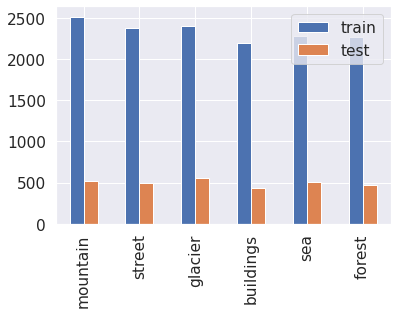

In [12]:
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar()
plt.show()

As we can see, is a good thing that we are dealing with balaced data.

## Visualize the data

In [13]:
# scale the data
train_images = train_images / 255.0 
test_images = test_images / 255.0

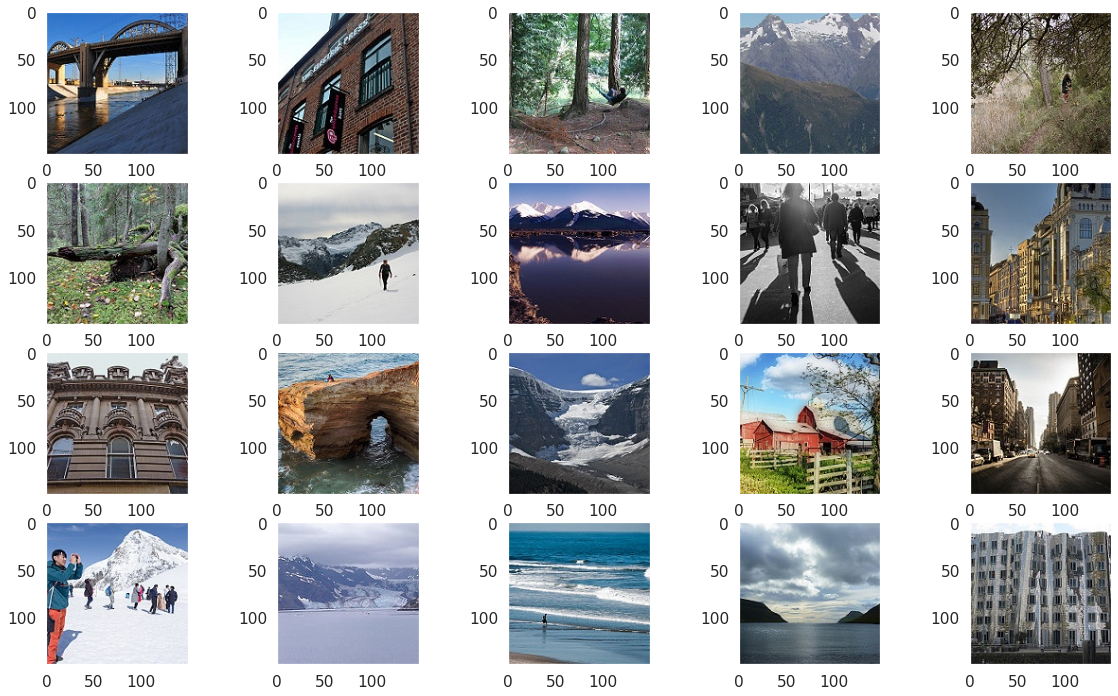

In [14]:
## let's visualize 20 random pictures from the training set
import random 
fig = plt.figure(figsize=(20, 12))
for i in range(20):
    index = random.randrange(0, 14034)
    image = np.asarray(train_images[index]).squeeze()
    fig.add_subplot(4, 5, i+1)
    plt.grid(False)
    plt.imshow(image)
plt.show()

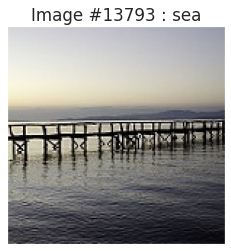

In [15]:
# let's display a random image an its label
index = random.randrange(0, 14034)
plt.figure()
plt.imshow(train_images[index])
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Image #{} : '.format(index) + class_names[train_labels[index]])
plt.show()

## Basic Machine Learing Model

I will use the **HOG Feature Descriptor** for extracting features from images and based on that features, I will train an **Support Vector Classifier** for the baseline model.

In [16]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

/opt/miniconda/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


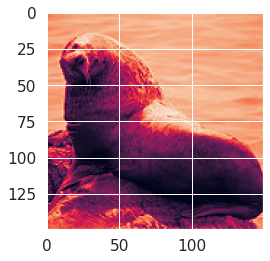

In [17]:
from skimage import color
# convert images to grayscale before calculating the HOG features for each image
train_gray = [ color.rgb2gray(i) for i in train_images ]
test_gray = [ color.rgb2gray(i) for i in test_images ]

plt.imshow(train_gray[42])

In [18]:
ppc = 16
hog_train_images = []
hog_train_features = []
for image in train_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2', visualize=True)
    hog_train_images.append(hog_image)
    hog_train_features.append(fd)

In [19]:
ppc = 16
hog_test_images = []
hog_test_features = []
for image in test_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2', visualize=True)
    hog_test_images.append(hog_image)
    hog_test_features.append(fd)

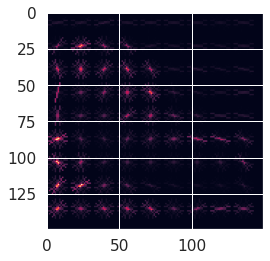

In [20]:
# let's see the gradients calulated by HOG of the same image 
plt.imshow(hog_train_images[42])

I will use grid search and cross validation to determine the best params for the **SVC** model.

In [21]:
# let's prepare the data first
train_labels = np.array(train_labels).reshape(len(train_labels), 1)
test_labels = np.array(test_labels).reshape(len(test_labels), 1)

hog_train_features = np.array(hog_train_features)
data_frame_train = np.hstack((hog_train_features,train_labels))
hog_test_features = np.array(hog_test_features)
data_frame_test = np.hstack((hog_test_features,test_labels))


x_train, x_test = data_frame_train[:,:-1], data_frame_test[:,:-1]
y_train, y_test = data_frame_train[:,-1:].ravel() , data_frame_test[:,-1:].ravel()

In [22]:
x_train

array([[0.03164363, 0.02350659, 0.03721029, ..., 0.17131917, 0.17979895,
        0.14064328],
       [0.02029377, 0.00907282, 0.04098115, ..., 0.04087445, 0.04970106,
        0.05604016],
       [0.03280611, 0.01106846, 0.09010343, ..., 0.10243784, 0.12227199,
        0.12315957],
       ...,
       [0.01387202, 0.04044933, 0.09978161, ..., 0.09652453, 0.05482382,
        0.03977939],
       [0.07660877, 0.09311525, 0.13846334, ..., 0.13961168, 0.071035  ,
        0.04620276],
       [0.09051181, 0.04773553, 0.04914328, ..., 0.05331194, 0.10939738,
        0.10529341]])

In [23]:
y_train[0]

4.0

In [60]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# selecting some params for the grid search
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [34]:
svm_model = SVC()
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
# display the results on test
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.7706666666666667


              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66       525
         1.0       0.85      0.83      0.84       501
         2.0       0.66      0.67      0.66       553
         3.0       0.84      0.81      0.83       437
         4.0       0.76      0.75      0.76       510
         5.0       0.90      0.92      0.91       474

    accuracy                           0.77      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.77      0.77      0.77      3000



In [35]:
# performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=3)
svm_model.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [36]:
# view the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# view the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_

Best score for training data: 0.7193244976485679 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [37]:
y_pred = final_model.predict(x_test)

In [38]:
# display the results on test
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.7303333333333333


              precision    recall  f1-score   support

         0.0       0.58      0.65      0.61       525
         1.0       0.81      0.81      0.81       501
         2.0       0.63      0.61      0.62       553
         3.0       0.80      0.74      0.77       437
         4.0       0.75      0.69      0.72       510
         5.0       0.87      0.90      0.88       474

    accuracy                           0.73      3000
   macro avg       0.74      0.73      0.74      3000
weighted avg       0.73      0.73      0.73      3000



In [42]:
y_pred

array([4., 1., 0., ..., 0., 2., 1.])

So we obtain some pretty good results, even on the base model with **77% accuracy**.
We can see that the model performs very well on predicting **streets** with more than **90% F1 score** and its weaker points are predicting **buildings** and **glaciers**.

## Basic CNN Model

I will build a simple **deep learning** model, using **CNNs** and **Pooling** layers to see if I can beat the SVM model.

In [24]:
# let's make the setup for using GPU
from ctypes import *
lib8 = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcublas.so.11')
lib1 = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcudart.so.11.0')
lib2 = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcublasLt.so.11')
lib3 = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcufft.so.10')
lib4 = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcurand.so.10')
lib5 = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcusolver.so.11')
lib6 = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcusparse.so.11')
lib7 = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcudnn.so.8')

In [25]:
# i will use 15 GB of GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
# Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=15000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized   
        print(e)

1 Physical GPUs, 1 Logical GPUs


I will use **ImagaDataGenerator** to code the generators that will yield batches of images, both for training and testing.

In [26]:
def train_val_generators(train_images, train_labels, test_images, test_labels, batch_size=32):

    train_datagen = ImageDataGenerator(
      validation_split=0.2,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )

    train_generator = train_datagen.flow(x=train_images,
                                       y=train_labels,
                                       subset='training',
                                       batch_size=batch_size) 
    validation_generator = train_datagen.flow(x=train_images,
                                       y=train_labels,
                                       subset='validation',
                                       batch_size=batch_size) 



    test_datagen = ImageDataGenerator()

    # Pass in the appropriate arguments to the flow method
    test_generator = test_datagen.flow(x=test_images,
                                       y=test_labels,
                                       batch_size=batch_size) 

    return train_generator, validation_generator, test_generator

In [27]:
# let's see if the function is working
train_generator, validation_generator, test_generator = train_val_generators(train_images, train_labels, test_images, test_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")
print(f"Images of test generator have shape: {test_generator.x.shape}")
print(f"Labels of test generator have shape: {test_generator.y.shape}")

Images of training generator have shape: (11228, 150, 150, 3)
Labels of training generator have shape: (11228, 1)
Images of validation generator have shape: (2806, 150, 150, 3)
Labels of validation generator have shape: (2806, 1)
Images of test generator have shape: (3000, 150, 150, 3)
Labels of test generator have shape: (3000, 1)


In [51]:
# now let's code the CNN
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        # 26 classes
        tf.keras.layers.Dense(6, activation='softmax')
  ])
    
    model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [71]:
# save model
model = create_model()

# train model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 351 steps, validate for 88 steps
Epoch 1/20
351/351 [==============================] - 53s 152ms/step - loss: 1.2745 - accuracy: 0.5371 - val_loss: 0.9739 - val_accuracy: 0.6222
Epoch 2/20
351/351 [==============================] - 54s 154ms/step - loss: 0.9576 - accuracy: 0.6417 - val_loss: 0.8996 - val_accuracy: 0.6629
Epoch 3/20
351/351 [==============================] - 54s 154ms/step - loss: 0.8975 - accuracy: 0.6606 - val_loss: 0.9117 - val_accuracy: 0.6507
Epoch 4/20
351/351 [==============================] - 54s 153ms/step - loss: 0.8461 - accuracy: 0.6864 - val_loss: 0.8227 - val_accuracy: 0.6921
Epoch 5/20
351/351 [==============================] - 54s 153ms/step - loss: 0.7847 - accuracy: 0.7083 - val_loss: 0.7626 - val_accuracy: 0.7167
Epoch 6/20
351/351 [==============================] - 54s 153ms/step - loss: 0.7528 - accuracy: 0.7233 - val_loss: 0.7260 - val_accuracy: 0.7359
Epoch 7/20
351/351 [=================

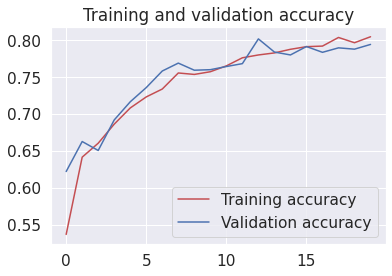

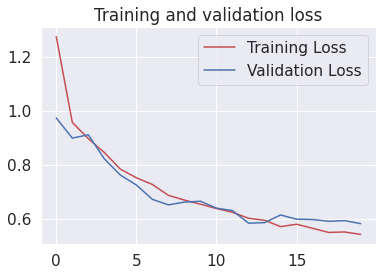

In [72]:
# let's see some infos about the training history
# we will look at the accuracy and loss on both training and validation generator

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:
# we should evaluate the model on the test set
test_loss = model.evaluate(test_generator)

  ...
    to  
  ['...']
94/94 [==============================] - 1s 6ms/step - loss: 0.5309 - accuracy: 0.8153


In [94]:
# get the predictions
predictions = model.predict_generator(generator=test_generator,
                                steps=test_generator.y.shape[0]/32,
                                max_queue_size=10,
                                workers=0,
                                use_multiprocessing=False,
                                verbose=0)

# Evaluate predictions
predictedClass = np.argmax(predictions, axis=1)
trueClass = test_generator.y[test_generator.index_array]

# create the confusion matrix
confusionMatrix = (confusion_matrix(
    y_true=trueClass,                                      
    y_pred=predictedClass))  
print(confusionMatrix)


[[375   9  90  17  32   2]
 [  3 416   0  71   2   9]
 [ 46  22 449  15  19   2]
 [  4  49   4 370   6   4]
 [ 33  16  46  32 378   5]
 [  3   8   1   4   0 458]]


In [95]:
# display the results on test
print("Accuracy: "+str(accuracy_score(trueClass, predictedClass)))
print('\n')
print(classification_report(trueClass, predictedClass))

Accuracy: 0.8153333333333334


              precision    recall  f1-score   support

           0       0.81      0.71      0.76       525
           1       0.80      0.83      0.81       501
           2       0.76      0.81      0.79       553
           3       0.73      0.85      0.78       437
           4       0.86      0.74      0.80       510
           5       0.95      0.97      0.96       474

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.81      3000



We imporved from the baseline model wit **81.5% accuracy** on test set. We cand see that the weights on the F1-score along the classes are similar with the baseline model: the model keeps predicting **the streets the best** and the **buildings and glaciers the weakest**.

## PCA


Next, I would like to use PCA for **dimensionality reduction**.

But first, let's use PCA for **visualization**.

In [101]:
train_images.shape

(14034, 150, 150, 3)

In [119]:
X_train = train_images.reshape(14034,3*150*150)
X_test = test_images.reshape(3000,3*150*150)

In [103]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) 
pca.fit(X_train)

PCA(n_components=2)

In [104]:
# let's see some characteristics about the components selected
print(pca.singular_values_)
print(pca.explained_variance_ratio_)
# the eigen vectors 
print(pca.components_)

[3888.4417 2863.8008]
[0.23133463 0.12548016]
[[-0.00434755 -0.00481414 -0.00625613 ... -0.00204156 -0.00223785
  -0.00275467]
 [-0.00387735 -0.00357877 -0.00295096 ...  0.0045675   0.0047316
   0.00516545]]


In [105]:
# let's plot the the the images based on the 2 principal components with the highest explained variance ratio
pca.components_[1].shape

(67500,)

In [107]:
vectors = pca.components_
# project the original date on the plane determined by the 2 pcincipal components
new_coordinates = np.matmul(vectors, X_train.T).T

In [108]:
labels = np.array(train_labels)
labels.shape

(14034, 1)

In [109]:
new_coordinates.shape

(14034, 2)

In [110]:
new_coordinates = np.concatenate((new_coordinates, labels), axis = 1)
new_coordinates.shape

(14034, 3)

In [111]:
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))
print(dataframe.head())

   1st_principal  2nd_principal  label
0    -154.921677      23.044823    4.0
1    -132.372147      19.484413    0.0
2    -161.621292     -23.128927    0.0
3     -58.614105      12.656338    1.0
4     -55.316143      20.794617    5.0


/opt/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


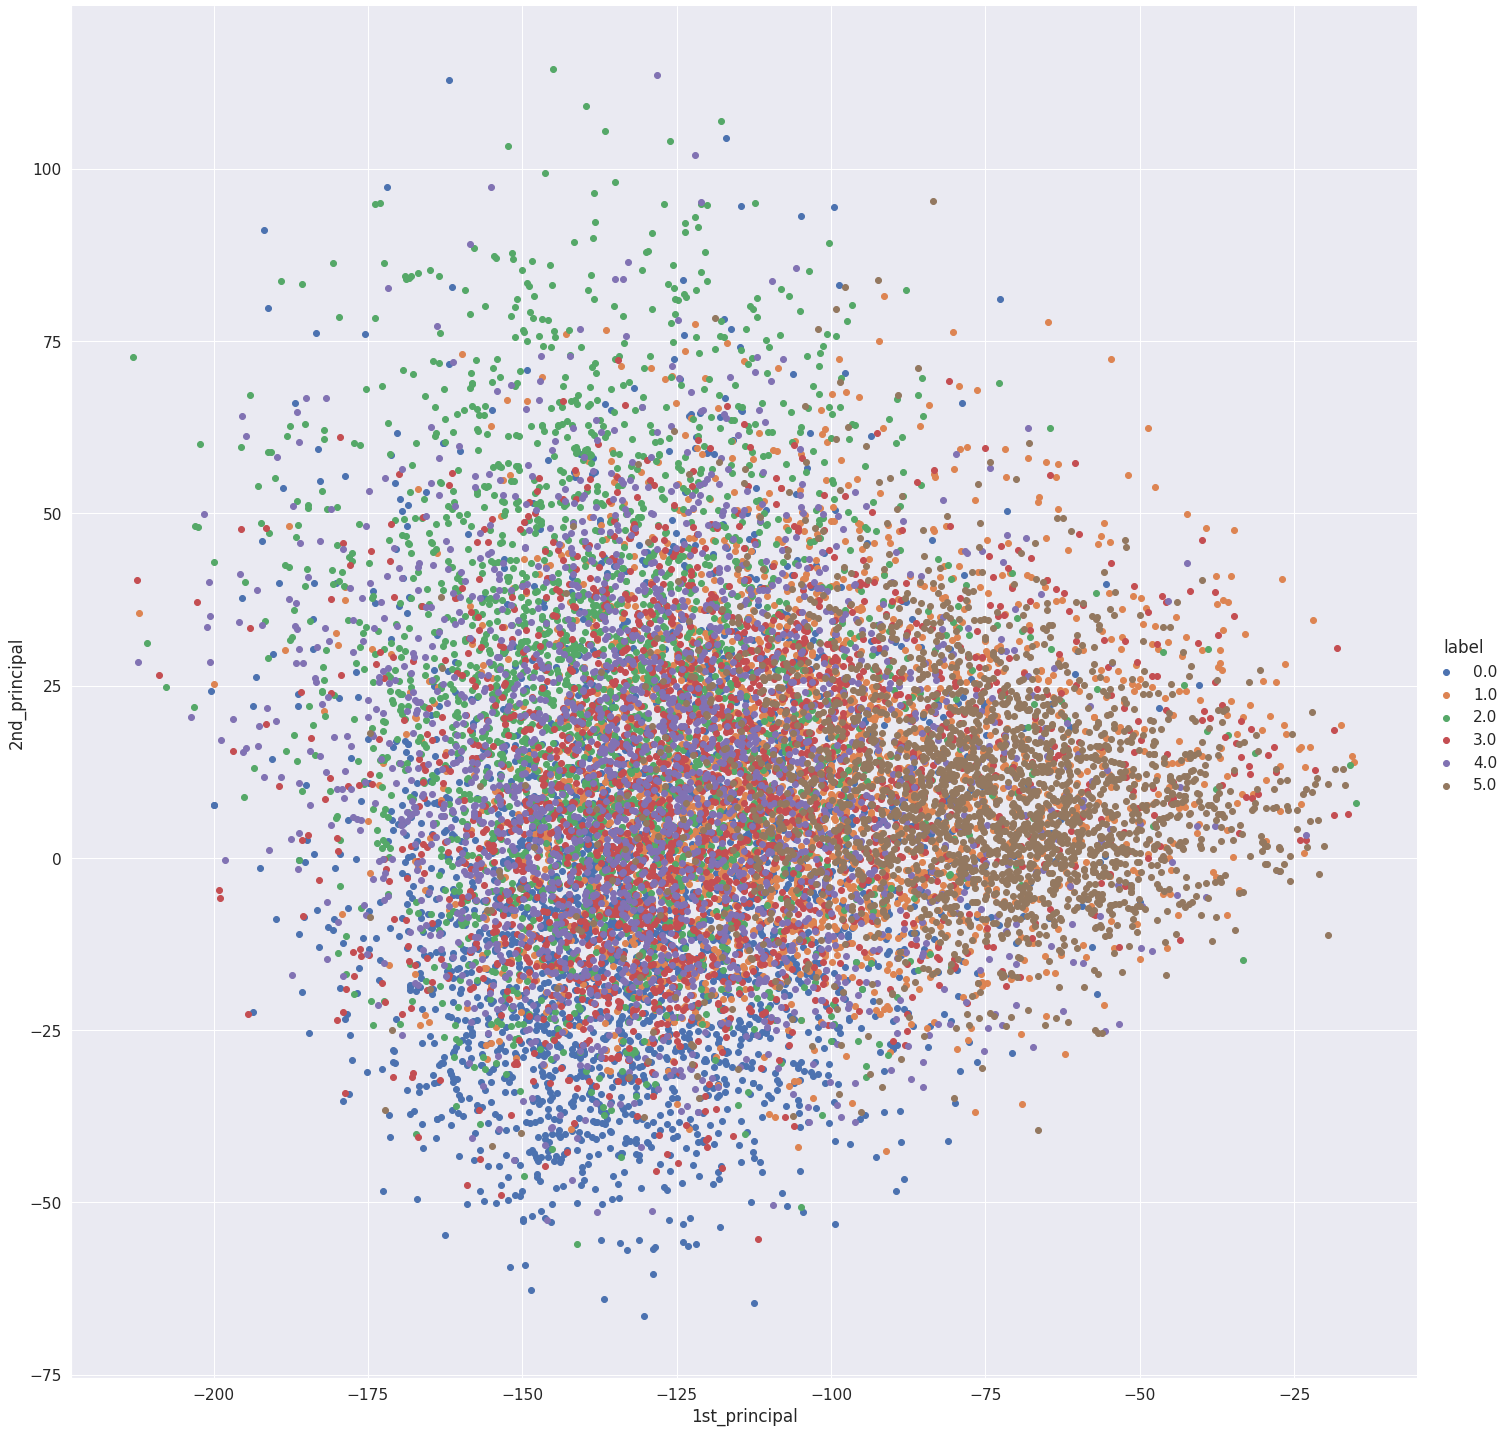

In [112]:
## plot

import seaborn as sns
sns.FacetGrid(dataframe, hue="label", size=20).map(plt.scatter, "1st_principal",  "2nd_principal").add_legend()
plt.show()

**Dimenisonality reduction**

In [120]:
# let's keep only the components that keep more than 85% variance
pca = PCA(n_components=0.85)

In [121]:
pca.fit(X_train)

PCA(n_components=0.85)

In [123]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [125]:
X_train.shape

(14034, 848)

In [127]:
X_test.shape

(3000, 848)

## ResNet50


Next, I will like to build a **ResNet50** from scratch. This is a large and very complex network and I want to see if it can top the performance of the smaller **CNN** . 

In [35]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
%matplotlib inline

I am going to implement two main types of blocks which are used in impementing ResNet: **the identity block** and **the convolutional block**. I will define a function for each block and a function that will assemble the **ResNet**.

**Identity Block**

In [36]:
def identity_block(x, filters):

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(tf.keras.activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(tf.keras.activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(tf.keras.activations.relu)(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(tf.keras.activations.relu)(x)

    return x


**Convolutional Block**

In [37]:
def convolutional_block(x, s, filters):

    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(tf.keras.activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(tf.keras.activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(tf.keras.activations.relu)(x)

    return x

**Build the ResNet with 50 layers**

In [38]:
 def resnet50():

    input_im = Input(shape=(train_images.shape[1], train_images.shape[2], train_images.shape[3])) 
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(tf.keras.activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = convolutional_block(x, s=1, filters=(64, 256))
    x = identity_block(x, filters=(64, 256))
    x = identity_block(x, filters=(64, 256))

    # 3rd stage

    x = convolutional_block(x, s=2, filters=(128, 512))
    x = identity_block(x, filters=(128, 512))
    x = identity_block(x, filters=(128, 512))
    x = identity_block(x, filters=(128, 512))

    # 4th stage

    x = convolutional_block(x, s=2, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))

    # 5th stage

    x = convolutional_block(x, s=2, filters=(512, 2048))
    x = identity_block(x, filters=(512, 2048))
    x = identity_block(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)                  
    x = layers.Dense(6, activation='softmax')(x)

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

In [39]:
def train_val_generators2(train_images, train_labels, test_images, test_labels, batch_size=32):
    
    y_cat_train = to_categorical(train_labels,6)
    y_cat_test= to_categorical(test_labels,6)

    train_datagen = ImageDataGenerator(
      validation_split=0.2,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )

    train_generator = train_datagen.flow(x=train_images,
                                       y=y_cat_train,
                                       subset='training',
                                       batch_size=batch_size) 
    validation_generator = train_datagen.flow(x=train_images,
                                              y=y_cat_train,
                                           subset='validation',
                                           batch_size=batch_size) 



    test_datagen = ImageDataGenerator()

    # Pass in the appropriate arguments to the flow method
    test_generator = test_datagen.flow(x=test_images,
                                       y=y_cat_test,
                                       batch_size=batch_size) 

    return train_generator, validation_generator, test_generator

In [40]:
# refactor the generatos
train_generator, validation_generator, test_generator = train_val_generators2(train_images, train_labels, test_images, test_labels, batch_size=24)
print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")
print(f"Images of test generator have shape: {test_generator.x.shape}")
print(f"Labels of test generator have shape: {test_generator.y.shape}")

Images of training generator have shape: (11228, 150, 150, 3)
Labels of training generator have shape: (11228, 6)
Images of validation generator have shape: (2806, 150, 150, 3)
Labels of validation generator have shape: (2806, 6)
Images of test generator have shape: (3000, 150, 150, 3)
Labels of test generator have shape: (3000, 6)


In [41]:
model = resnet50()
print(model.summary())

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 75, 75, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 75, 75, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [44]:
resnet_train = model.fit(train_generator,
                          epochs=50,
                          validation_data=validation_generator
                        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 468 steps, validate for 117 steps
Epoch 1/50
468/468 [==============================] - 65s 138ms/step - loss: 19.3912 - acc: 0.3337 - val_loss: 19.0405 - val_acc: 0.3435
Epoch 2/50
468/468 [==============================] - 56s 120ms/step - loss: 18.0311 - acc: 0.4642 - val_loss: 17.2636 - val_acc: 0.5481
Epoch 3/50
468/468 [==============================] - 57s 121ms/step - loss: 16.6383 - acc: 0.5061 - val_loss: 15.8594 - val_acc: 0.5478
Epoch 4/50
468/468 [==============================] - 56s 119ms/step - loss: 15.1496 - acc: 0.5446 - val_loss: 14.3226 - val_acc: 0.6066
Epoch 5/50
468/468 [==============================] - 56s 119ms/step - loss: 13.6525 - acc: 0.5680 - val_loss: 12.8531 - val_acc: 0.6415
Epoch 6/50
468/468 [==============================] - 56s 120ms/step - loss: 12.1979 - acc: 0.5939 - val_loss: 11.3979 - val_acc: 0.6536
Epoch 7/50
468/468 [==============================] - 55s 118ms/step - loss: 10.8412

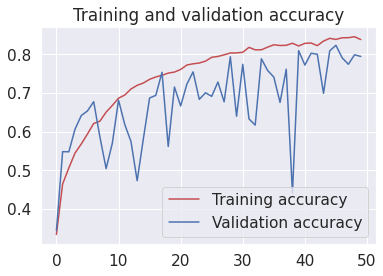

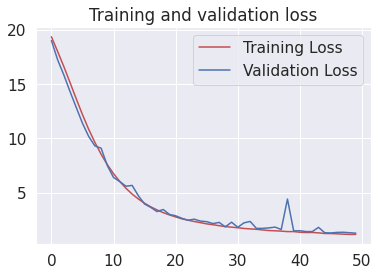

In [47]:
# let's see some infos about the training history
# we will look at the accuracy and loss on both training and validation generator

acc = resnet_train.history['acc']
val_acc = resnet_train.history['val_acc']
loss = resnet_train.history['loss']
val_loss = resnet_train.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [48]:
# we should evaluate the model on the test set
test_loss = model.evaluate(test_generator)

  ...
    to  
  ['...']
125/125 [==============================] - 3s 21ms/step - loss: 1.3450 - acc: 0.7690


In [61]:
from sklearn.metrics import accuracy_score
# get the predictions
predictions = model.predict_generator(generator=test_generator,
                                max_queue_size=10,
                                workers=0,
                                use_multiprocessing=False,
                                verbose=0)

# Evaluate predictions
predictedClass = np.argmax(predictions, axis=1)
trueClass = test_generator.y[test_generator.index_array]
trueClass = np.argmax(trueClass, axis=1)


# display the results on test
print("Accuracy: "+str(accuracy_score(trueClass, predictedClass)))
print('\n')
print(classification_report(trueClass, predictedClass))

Accuracy: 0.769


              precision    recall  f1-score   support

           0       0.87      0.54      0.66       525
           1       0.81      0.86      0.83       501
           2       0.89      0.58      0.70       553
           3       0.82      0.78      0.80       437
           4       0.65      0.92      0.76       510
           5       0.72      0.99      0.84       474

    accuracy                           0.77      3000
   macro avg       0.79      0.78      0.76      3000
weighted avg       0.79      0.77      0.76      3000



So, the ResNet doesn't outperform the simple CNN, and has the same accuracy as the baseline model. 

In [62]:
# let's save the model
model.save("resnet50.h5")

## Transfer learning

Next, I will use 3 pretrained famous models **VGG16**, **IceptionV3** and, of course, **ResNet**(maybe this one will have better results than the one I built from scratch). This models were traing on the **imagenet** dataset, which contains 1000 classes.

**ResNet**

Let's start with the ResNet, because I couldn't get over the face that I got only 77% accuracy.

In [67]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop

file='resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model=ResNet50( input_shape=(150,150,3),
                                  include_top=False,
                                  weights=None
                                   )
pretrained_model.load_weights(file)
for layer in pretrained_model.layers:
     layer.trainable = False
        
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of resnet : output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)

model_resnet = Model(pretrained_model.input, x)
                     
model_resnet.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

last layer of resnet : output shape:  (None, 5, 5, 2048)


In [71]:
resnet_train = model.fit(train_generator,
                          epochs=1,
                          validation_data=validation_generator
                        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 468 steps, validate for 117 steps
468/468 [==============================] - 62s 132ms/step - loss: 0.9678 - acc: 0.8517 - val_loss: 1.0136 - val_acc: 0.8368


In [72]:
# evaluate the model on the test set
test_loss = model.evaluate(test_generator)

  ...
    to  
  ['...']
125/125 [==============================] - 3s 23ms/step - loss: 1.0496 - acc: 0.8260


In [74]:
from sklearn.metrics import accuracy_score
# get the predictions
predictions = model.predict_generator(generator=test_generator,
                                max_queue_size=10,
                                workers=0,
                                use_multiprocessing=False,
                                verbose=0)

# Evaluate predictions
predictedClass = np.argmax(predictions, axis=1)
trueClass = test_generator.y[test_generator.index_array]
trueClass = np.argmax(trueClass, axis=1)


# display the results on test
print("Accuracy: "+str(accuracy_score(trueClass, predictedClass)))
print('\n')
print(classification_report(trueClass, predictedClass))

Accuracy: 0.826


              precision    recall  f1-score   support

           0       0.79      0.73      0.76       525
           1       0.88      0.83      0.86       501
           2       0.85      0.71      0.78       553
           3       0.89      0.78      0.83       437
           4       0.74      0.93      0.83       510
           5       0.84      0.99      0.91       474

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.82      3000



These are the best results so far

In [75]:
# let's save the model
model.save("resnet_pretrained.h5")

## VGG-16

In [77]:
from tensorflow.keras.applications import VGG16

file='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model=VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights =None)
pretrained_model.load_weights(file)

for layer in pretrained_model.layers:
     layer.trainable = False

last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

last layer of vgg : output shape:  (None, 4, 4, 512)


In [80]:
vgg_train = model.fit(train_generator,
                          epochs=1,
                          validation_data=validation_generator
                        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 468 steps, validate for 117 steps
468/468 [==============================] - 55s 117ms/step - loss: 0.7417 - acc: 0.8825 - val_loss: 0.8296 - val_acc: 0.8574


In [81]:
# evaluate the model on the test set
test_loss = model.evaluate(test_generator)

  ...
    to  
  ['...']
125/125 [==============================] - 2s 19ms/step - loss: 0.8050 - acc: 0.8723


In [82]:
from sklearn.metrics import accuracy_score
# get the predictions
predictions = model.predict_generator(generator=test_generator,
                                max_queue_size=10,
                                workers=0,
                                use_multiprocessing=False,
                                verbose=0)

# Evaluate predictions
predictedClass = np.argmax(predictions, axis=1)
trueClass = test_generator.y[test_generator.index_array]
trueClass = np.argmax(trueClass, axis=1)


# display the results on test
print("Accuracy: "+str(accuracy_score(trueClass, predictedClass)))
print('\n')
print(classification_report(trueClass, predictedClass))

Accuracy: 0.8723333333333333


              precision    recall  f1-score   support

           0       0.85      0.83      0.84       525
           1       0.87      0.94      0.90       501
           2       0.88      0.75      0.81       553
           3       0.92      0.82      0.86       437
           4       0.80      0.92      0.86       510
           5       0.94      0.99      0.96       474

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



We got some impresive results with this model, better than with ResNet

In [83]:
# let's save the model
model.save("vgg16.h5")

## InceptionV3

In [90]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop (1).h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(file)

for layer in pre_trained_model.layers:
     layer.trainable = False
        
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer of inceptionV3 output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

last layer of inceptionV3 output shape:  (None, 7, 7, 768)


In [94]:
inception_train = model.fit(train_generator,
                          epochs=1,
                          validation_data=validation_generator
                        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 468 steps, validate for 117 steps
468/468 [==============================] - 58s 123ms/step - loss: 0.3485 - acc: 0.8943 - val_loss: 1.5780 - val_acc: 0.8478


In [95]:
# evaluate the model on the test set
test_loss = model.evaluate(test_generator)

  ...
    to  
  ['...']
125/125 [==============================] - 2s 14ms/step - loss: 1.3427 - acc: 0.8783


In [96]:
from sklearn.metrics import accuracy_score
# get the predictions
predictions = model.predict_generator(generator=test_generator,
                                max_queue_size=10,
                                workers=0,
                                use_multiprocessing=False,
                                verbose=0)

# Evaluate predictions
predictedClass = np.argmax(predictions, axis=1)
trueClass = test_generator.y[test_generator.index_array]
trueClass = np.argmax(trueClass, axis=1)


# display the results on test
print("Accuracy: "+str(accuracy_score(trueClass, predictedClass)))
print('\n')
print(classification_report(trueClass, predictedClass))

Accuracy: 0.8783333333333333


              precision    recall  f1-score   support

           0       0.77      0.87      0.82       525
           1       0.87      0.96      0.91       501
           2       0.80      0.83      0.81       553
           3       0.93      0.90      0.91       437
           4       0.97      0.80      0.88       510
           5       1.00      0.92      0.96       474

    accuracy                           0.88      3000
   macro avg       0.89      0.88      0.88      3000
weighted avg       0.89      0.88      0.88      3000



In [97]:
# create the confusion matrix
confusionMatrix = (confusion_matrix(
    y_true=trueClass,                                      
    y_pred=predictedClass))  
print(confusionMatrix)

[[458   4  58   4   1   0]
 [  0 483   0  17   1   0]
 [ 82   6 457   0   8   0]
 [  1  42   1 393   0   0]
 [ 42   6  43   9 410   0]
 [  9  17  13   0   1 434]]


In [98]:
# let's save the model
model.save("inception.h5")

## Conclusions

As expected, the best models were the ones used with **transfer learning**. Out of the 3 transfer learning models, the **InceptionV3** was the best one with 88% accuracy on test. We can see that it predicted **forests**, **mountains** and **streets** with more than 90% F1-score. The most mistakes were made confusing **buildings** and **glaciers**. 
I think the scope of this project was achived: using diiferent machine learning and deep learning techniques, training many models, trying to find the best one in predicting the classes with good accuracy. 